# Baseline: Logistic Regression + TF-IDF

In this notebook I'm going to create a strong baseline model using classic ML algorithms. 

In [2]:
# !pip install skl2onnx==1.12.0 onnxruntime==1.13.1 protobuf==3.20.1 optuna==3.0.4

In [27]:
# !pip install --no-cache-dir git+https://github.com/optuna/optuna

## Imports

In [83]:
import os
import pickle
from pathlib import Path
from collections import Counter

In [84]:
import optuna
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [85]:
import onnxruntime as rt
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

In [86]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [87]:
SEED = 42

## Paths

### Input

In [88]:
relative_path = os.path.join("../../../", "data")
sentiment_analysis_data_path = os.path.join(relative_path, "3_sentiment_analysis")

### Output

In [89]:
SAVED_MODELS_PATH = "saved_models"
Path(SAVED_MODELS_PATH).mkdir(parents=True, exist_ok=True)

## Parameters

In [94]:
F1_AVERAGING = "micro"

VERSION = "0.1.0"

## Loading data

In [91]:
reviews = pd.read_parquet(
    os.path.join(sentiment_analysis_data_path, "split_reviews.parquet")
)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206537 entries, 0 to 206536
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   sentiment  206537 non-null  category
 1   review     206537 non-null  object  
 2   show_id    206537 non-null  int64   
 3   fold       206537 non-null  object  
dtypes: category(1), int64(1), object(2)
memory usage: 4.9+ MB


In [92]:
train = reviews[reviews["fold"] == "train"]
test = reviews[reviews["fold"] == "test"]
dev = reviews[reviews["fold"] == "dev"]

del reviews

In [93]:
X_train, X_test, X_dev, y_train, y_test, y_dev = (
    train["review"].str.replace("<p>", " ").values.tolist(),
    test["review"].str.replace("<p>", " ").values.tolist(),
    dev["review"].str.replace("<p>", " ").values.tolist(),
    train["sentiment"].values.tolist(),
    test["sentiment"].values.tolist(),
    dev["sentiment"].values.tolist(),
)

len(X_train), len(X_test), len(X_dev), len(y_train), len(y_test), len(y_dev)
del train, test, dev

## Evaluation metrics

In [81]:
target_counts = Counter(y_test + y_dev)

total = sum(target_counts.values(), 0.0)
for key in target_counts:
    target_counts[key] /= total

print(target_counts)

Counter({'positive': 0.7202801717181498, 'neutral': 0.15002743617055614, 'negative': 0.12969239211129402})


## Investigation

For baseline model, I've decided to start with TF-IDF and Logistic Regression.

### Text Encoding

#### Hyperparameter Investigation

Instead of using `TfidfVectorizer` to check different hyperparameters it will be faster to use `CountVectorizer`, because it has almost the same hyperparameters.

##### `lowercase`

In [12]:
vectorizer = CountVectorizer(lowercase=False)
vectors_wo_lowercase = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors_wo_lowercase.shape} with lowercase turned off"
)

The size of the train dataset is (185883, 786860) with lowercase turned off


In [13]:
vectorizer = CountVectorizer()
vectors_w_lowercase = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors_w_lowercase.shape} with lowercase turned on"
)

The size of the train dataset is (185883, 670194) with lowercase turned on


In [14]:
vectors_wo_lowercase.shape[1] - vectors_w_lowercase.shape[1]

116666

The difference in vocabulary size between cased and uncased models is more than 100 000, so we better stick to lowercase 

##### `max_df` and `min_df`

`min_df` is used for removing terms that appear **too infrequently**. For example:

 - `min_df = 0.01` means "ignore terms that appear in **less than 1% of the documents**".
 - `min_df = 5` means "ignore terms that appear in **less than 5 documents**".  
 
The default `min_df` is `1`, which means "ignore terms that appear in **less than 1 document**".  
Thus, the default setting does not ignore any terms.

`max_df` is used for removing terms that appear **too frequently**, also known as "corpus-specific stop words". For example:

 - `max_df = 0.5` means "ignore terms that appear in **more than 50% of the documents**".
 - `max_df = 25` means "ignore terms that appear in **more than 25 documents**".  
 
The default `max_df` is `1.0`, which means "ignore terms that appear in **more than 100% of the documents**".  
Thus, the default setting does not ignore any terms.

In [15]:
vectorizer.get_feature_names_out()[:50]

array(['00', '000', '0000', '00000', '000000',
       '000000000000000000попкорн000000000000', '000000000000001',
       '000000000000на', '00000000000во', '00000000000данной',
       '00000000000есть000000000000000',
       '00000000000есть000000000000000000', '0000000000жевать',
       '0000000000ненавижу00000000', '00000000016', '000000000надо',
       '000000000разговаривать0000000000', '00000000визуальная',
       '00000001', '00000громко', '00000точек', '00001', '00007', '0001',
       '0002', '000доктора', '000какой', '000косметические', '000р',
       '000теряются', '001', '002', '003', '00381', '006', '007', '00в',
       '00вых', '00м', '00по', '00с', '00х', '00ые', '00ых', '01', '011',
       '013', '014', '015', '01минуту'], dtype=object)

We can see that if we do not limit the vocabulary, we will have very infrequent words in the corpora, so we better do it.  
For that we have to choose the `min_df` and `max_df` thresholds.

In [16]:
vectorizer = CountVectorizer(min_df=0.8)
vectors = vectorizer.fit_transform(X_train)
vectors.shape

(185883, 7)

In [17]:
vectorizer.get_feature_names_out()

array(['как', 'на', 'не', 'но', 'то', 'что', 'это'], dtype=object)

These words are in 80% of all reviews, and this is understandable, since these are particles, prepositions and conjunctions.

In [18]:
MIN_DF = 0.01
vectorizer = CountVectorizer(min_df=MIN_DF)
vectors = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors.shape} with lowercase turned on and min_df={MIN_DF}"
)

The size of the train dataset is (185883, 3284) with lowercase turned on and min_df=0.01


In [19]:
vectorizer.get_feature_names_out()[:50]

array(['10', '100', '11', '12', '13', '15', '16', '18', '20', '2012',
       '21', '30', '3d', '40', '50', '60', '70', '80', '90', 'dc',
       'marvel', 'of', 'the', 'абсолютно', 'аватар', 'автор', 'автора',
       'авторов', 'авторы', 'аж', 'актер', 'актера', 'актерам',
       'актерами', 'актерах', 'актеров', 'актером', 'актерская',
       'актерский', 'актерского', 'актерской', 'актерскую', 'актеры',
       'актриса', 'актрисы', 'актёр', 'актёра', 'актёров', 'актёрская',
       'актёрский'], dtype=object)

Now it's much better. We removed unpopular tokens and reduced the vocabulary from ~670K to 3.3K tokens.

In [20]:
MIN_DF = 0.01
MAX_DF = 0.9

vectorizer = CountVectorizer(min_df=MIN_DF, max_df=MAX_DF)
vectors = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors.shape} with lowercase turned on and min_df={MIN_DF} and max_df={MAX_DF}"
)

The size of the train dataset is (185883, 3281) with lowercase turned on and min_df=0.01 and max_df=0.9


I'll leave default value of `max_df` - 1.

##### `ngram_range`

The lower and upper boundary of the range of n-values for different n-grams to be extracted.  
All values of n such that min_n ≤ n ≤ max_n will be used.   

For example a `ngram_range` of `(1, 1)` means only `unigrams`, `(1, 2)` means `unigrams` and `bigrams`, and `(2, 2)` means only `bigrams`.

In [50]:
NGRAM_RANGE = (1, 2)
MIN_DF = 0.01

vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, min_df=MIN_DF)

train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
dev_vectors = vectorizer.transform(X_dev)

print(
    f"The size of the train dataset is {train_vectors.shape} with lowercase turned on and min_df={MIN_DF} and ngram_range={NGRAM_RANGE}"
)

The size of the train dataset is (175556, 4624) with lowercase turned on and min_df=0.01 and ngram_range=(1, 2)


In [30]:
vectorizer.get_feature_names_out()[:50]

array(['10', '10 лет', '100', '11', '12', '13', '15', '16', '18', '20',
       '2012', '21', '30', '3d', '40', '50', '60', '70', '80', '90', 'dc',
       'marvel', 'of', 'the', 'абсолютно', 'абсолютно все',
       'абсолютно не', 'аватар', 'автор', 'автора', 'авторов', 'авторы',
       'аж', 'актер', 'актера', 'актерам', 'актерами', 'актерах',
       'актеров', 'актером', 'актерская', 'актерская игра', 'актерский',
       'актерский состав', 'актерского', 'актерской', 'актерской игры',
       'актерскую', 'актерскую игру', 'актеры'], dtype=object)

From my experience, usually `(1, 2)` is a good default value for the `ngram_range`. Sometimes `(1, 3)` can be a little bit better.

### Classification

For the base model, I always use logistic regression as a classifier.

In [58]:
log_reg = LogisticRegression(
    C=1, random_state=SEED, class_weight="balanced", solver="saga", max_iter=10_000
)

In [59]:
log_reg.fit(train_vectors, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=10000,
                   random_state=42, solver='saga')

In [62]:
pred_labels = log_reg.predict(val_vectors)
f1 = f1_score(y_val, pred_labels, average=F1_AVERAGING)

print(f"F1 score with {F1_AVERAGING}-averaging is {f1.round(5)}")

F1 score with micro-averaging is 0.72584


#### Hyperparameter Investigation

For Logistic Regression we can tune the regularization strength (`C`), `solver` and `penalty` type.  
In this notebook, I will only tune the first one using Optuna.

In [36]:
distributions = {
    "C": optuna.distributions.FloatDistribution(1e-7, 10.0, log=True),
}

In [37]:
study = optuna.create_study(direction="maximize")
n_trials = 20

for _ in range(n_trials):
    trial = study.ask(distributions)  # pass the pre-defined distributions.

    # two hyperparameters are already sampled from the pre-defined distributions
    C = trial.params["C"]

    clf = LogisticRegression(C=C, solver="saga")
    clf.fit(train_vectors, y_train)

    pred_labels = log_reg.predict(val_vectors)
    f1 = f1_score(y_val, pred_labels, average=F1_AVERAGING)

    study.tell(trial, f1)

[I 2022-12-27 20:35:33,917] A new study created in memory with name: no-name-3a2abeb1-9cca-488f-a2dd-816bb1fe7345


In [38]:
study.best_params, study.best_value

({'C': 0.36318241244470856}, 0.8027887160286618)

After tuning the regularization strength (`C`) we realize that there is no point in changing the default value of `C`, because we are getting the same results.

Let's now make a simple pipeline with two components: `TfidfVectorizer` and `LogisticRegression` to save model in one file.

## Modelling

### Vectorizing reviews with TF-IDF

In [68]:
stages = []

In [69]:
vectorizer_params = {
    "min_df": 0.01,
    "ngram_range": (1, 2),
    "max_features": 10_000,
}

review_vectorizer = TfidfVectorizer(**vectorizer_params)

stages.append(("vectorizer", review_vectorizer))

### Classifying reviews with Logistic Regression

In [70]:
log_reg = LogisticRegression(
    C=1,
    random_state=SEED,
    solver="saga",
    max_iter=10_000,
    class_weight="balanced",
)

stages.append(("classifier", log_reg))

### Training

In [71]:
pipe = Pipeline(stages)
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=10000, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced',
                                    max_iter=10000, random_state=42,
                                    solver='saga'))])

### Evaluation

In [72]:
pred_labels = pipe.predict(X_test)
f1 = f1_score(y_test, pred_labels, average=F1_AVERAGING)

print(f"F1 score with {F1_AVERAGING}-averaging is {f1.round(5)}")

F1 score with micro-averaging is 0.72292


Now we have our pipeline and we can save it.  
We have several choices: ONNX, joblib, pickle.

## Saving the pipeline

### ONNX

#### Converting

In [34]:
pipe_path = os.path.join(SAVED_MODELS_PATH, f"TfIdfLogRegSentiment-{VERSION}.onnx")

In [35]:
initial_type = [("input", StringTensorType([None, 1]))]
seps = {
    TfidfVectorizer: {
        "separators": [
            " ",
            ".",
            "\\?",
            ",",
            ";",
            ":",
            "!",
            "\\(",
            "\\)",
            "\n",
            '"',
            "'",
            "-",
            "\\[",
            "\\]",
            "@",
        ]
    }
}

model_onnx = convert_sklearn(
    pipe, "tfidf", initial_types=initial_type, options=seps, target_opset=12
)

/home/extremesarova/projects/shows_analysis/venv/lib/python3.8/site-packages/skl2onnx/common/_container.py:695: UserWarning: Unable to find operator 'Tokenizer' in domain 'com.microsoft' in ONNX, op_version is forced to 1.
  warnings.warn(


#### Saving

In [36]:
with open(pipe_path, "wb") as f:
    f.write(model_onnx.SerializeToString())

#### Comparing results

In [37]:
sess = rt.InferenceSession(pipe_path)

input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

inputs = {"input": [[input] for input in X_test]}

In [38]:
pred_onx = sess.run(None, inputs)
f1 = f1_score(y_test, pred_onx[0], average=F1_AVERAGING)

print(f"F1 score with {F1_AVERAGING}-averaging is {f1.round(3)}")

F1 score with micro-averaging is 0.72


We see such a big performance drop because ONNX has some problems with conversion of TF-IDF models.  

My 'go-to' solution for saving models was ONNX, but this performance deterioration is not worth it. I'll try alternative ways to save the pipeline. 

### Pickle

#### Saving

In [73]:
pipe_path = os.path.join(SAVED_MODELS_PATH, f"TfIdfLogRegSentiment-{VERSION}.pkl")

In [74]:
with open(pipe_path, "wb") as f:
    pickle.dump(pipe, f)

#### Comparing results

In [75]:
with open(pipe_path, "rb") as f:
    loaded_pipe = pickle.load(f)

loaded_pipe

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=10000, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced',
                                    max_iter=10000, random_state=42,
                                    solver='saga'))])

In [76]:
pred_labels_loaded = loaded_pipe.predict(X_test)
f1_loaded = f1_score(y_test, pred_labels_loaded, average=F1_AVERAGING)

print(f"F1 score with {F1_AVERAGING}-averaging is {f1_loaded.round(5)}")

F1 score with micro-averaging is 0.72292


Yep, pickle works well, but has some [security & maintainability issues](https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations).

## Error analysis

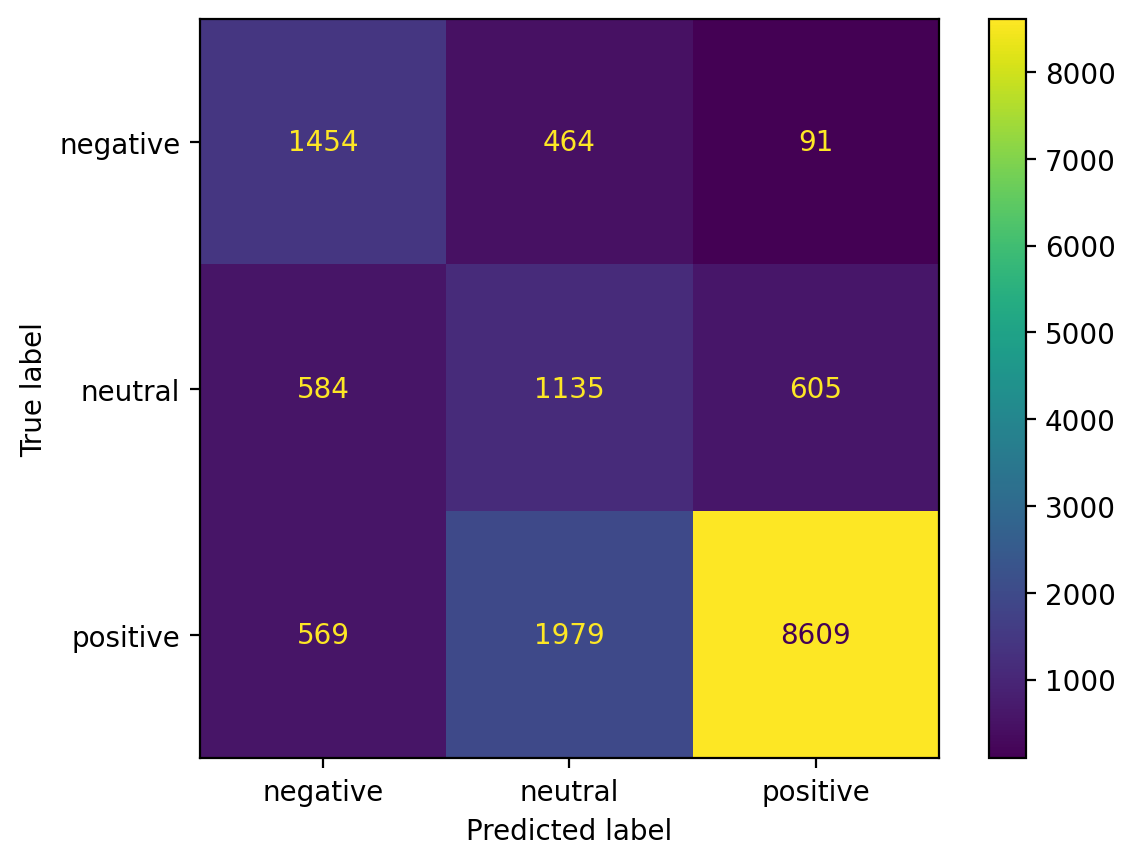

In [77]:
cm = confusion_matrix(y_test, pred_labels_loaded, labels=loaded_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=loaded_pipe.classes_)

disp.plot()
